In [1]:
%load_ext autoreload
%autoreload

import json
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import tqdm
import random
import torch
import sklearn
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
import inlp, inlp_dataset_handler, inlp_linear_model
import copy

I0224 18:34:31.487960 140559703516992 file_utils.py:35] PyTorch version 1.3.1 available.
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

In [2]:
with open('tweets.above-120.jsonl', "r", encoding = "utf-8") as f:
  lines = f.readlines()

all_tweets = []

for line in tqdm_notebook(lines[:]):
    d = json.loads(line)
    text = d["text"]
    lang = d["lang"]
    if lang is not None and "http" not in text and "@" not in text:
        
        all_tweets.append({"text": text.replace("\n", ".").lower(), "lang": lang})

In [4]:
data = []
n = 2000

langs = ["en", "ar", "es", "pt", "it", "fr", "in", "hi", "de", "ru", "nl", "ja", "th", "tl"]
langs = ["en", "es", "it", "pt", "ru", "hi", "de", "fr"]
for lang in langs:    
    lang_tweets = [d for d in all_tweets if d["lang"] == lang]
    print(lang, len(lang_tweets))
    for i in range(n):
        tweet = random.choice(lang_tweets)
        data.append({"lang": lang, "text": tweet["text"]})

en 44735
es 11434
it 730
pt 16348
ru 1128
hi 2703
de 489
fr 2235


In [5]:
from collections import Counter
all_langs = [d["lang"] for d in all_tweets]
counter = Counter(all_langs)
print(counter.most_common(100))

[('en', 44735), ('pt', 16348), ('es', 11434), ('ar', 6116), ('in', 5788), ('tr', 3822), ('hi', 2703), ('tl', 2495), ('fr', 2235), ('ja', 2128), ('th', 1138), ('ru', 1128), ('it', 730), ('und', 683), ('de', 489), ('ur', 482), ('ht', 467), ('fa', 366), ('nl', 340), ('cy', 238), ('ko', 200), ('pl', 188), ('ca', 164), ('fi', 154), ('iw', 150), ('sv', 138), ('et', 89), ('ne', 75), ('da', 73), ('el', 68), ('mr', 68), ('ta', 65), ('cs', 65), ('uk', 64), ('zh', 51), ('bn', 39), ('ro', 35), ('ml', 35), ('hu', 27), ('lv', 27), ('sl', 27), ('no', 25), ('sr', 23), ('te', 22), ('kn', 21), ('vi', 15), ('si', 12), ('or', 11), ('ps', 10), ('is', 9), ('bg', 8), ('lt', 8), ('ckb', 8), ('eu', 6), ('gu', 4), ('sd', 3), ('pa', 3), ('my', 2), ('dv', 2), ('am', 2)]


## Run BERT

In [6]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-base-multilingual-uncased", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        self.model = BertModel.from_pretrained('bert-base-multilingual-uncased', config = config)

        #config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        #self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
        
        #config = AlbertConfig.from_pretrained("albert-xlarge-v2", output_hidden_states=True)
        #self.tokenizer = AlbertTokenizer.from_pretrained("albert-xlarge-v2")
        #self.model = AlbertModel.from_pretrained("albert-xlarge-v2", config = config)
        #config = RobertaConfig.from_pretrained("roberta-large", output_hidden_states=True)
        #self.tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
        #self.model = RobertaModel.from_pretrained('roberta-large', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str], capitalize = False) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        if capitalize:
            
            w = list(original_sentence[0])
            w[0] = w[0].upper()
            
            original_sentence[0] = "".join(w)
            
        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            predictions = torch.cat([outputs[2][l] for l in layers], axis = 2).detach().cpu().numpy()
            
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok)
        
        
        
def collect_bert_states(bert, data: List[Tuple], layers: List[int], strategy = "mean"):
    
        for i,d in tqdm.notebook.tqdm(enumerate(data), total = len(data)):

            text = d["text"]
            sent = " ".join(text)
            preds, orig2tok = bert.encode(sent, layers = layers)
        
            if strategy == "sum":
                states = np.sum(preds, axis = 0)
            elif strategy == "cls":
                states = preds[0]
            elif strategy == "rand-word":
                states = preds[random.choice(range(len(preds)))]
            data[i]["vec"] = states
    
        return data

In [7]:
bert = BertEncoder(device = "cuda")

I0224 18:35:19.096427 140559703516992 file_utils.py:362] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json not found in cache or force_download set to True, downloading to /tmp/tmpfmkwddgt
I0224 18:35:19.840832 140559703516992 file_utils.py:377] copying /tmp/tmpfmkwddgt to cache at /home/nlp/ravfogs/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.c7892120c5a9b21e515abc904e398dbabddf9510b122f659063cbf361fe16868
I0224 18:35:19.844861 140559703516992 file_utils.py:381] creating metadata file for /home/nlp/ravfogs/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.c7892120c5a9b21e515abc904e398dbabddf9510b122f659063cbf361fe16868
I0224 18:35:19.848146 140559703516992 file_utils.py:390] removing temp file /tmp/tmpfmkwddgt
I0224 18:35:19.850266 140559703516992 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/be

In [8]:
data_with_states = collect_bert_states(bert, copy.deepcopy(data), layers = [-1], strategy = "cls")

In [10]:
import pickle

with open("data_with_bert-large_states.pickle", "wb") as f:
    
    pickle.dump(data_with_states, f)

## TSNE by language (Before INLP)

In [34]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue", "green", "orange", "black", "grey", "purple", "pink", "brown", "cyan", "magenta", "gold", "brown"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        plt.scatter(vecs_2d[labels == label, 0], vecs_2d[labels == label, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha = 0.3)
  plt.legend()
  

  plt.title(title)
  plt.show()

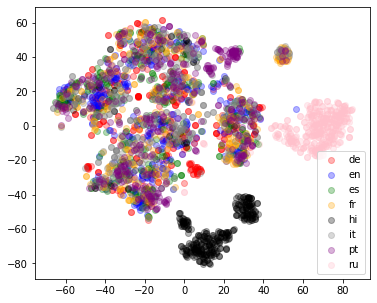

In [35]:
random.shuffle(data_with_states)
vecs = np.array([d["vec"] for d in data_with_states][:])
labels_lang = np.array([d["lang"] for d in data_with_states][:])
tsne(vecs[:3000], labels_lang[:3000])

## Classify language

In [36]:
l = int(len(vecs) * 0.9)
x_train_cls, x_dev_cls = vecs[:l], vecs[l:]
y_train_cls, y_dev_cls = labels_lang[:l], labels_lang[l:]
model = SGDClassifier(max_iter = 1000, alpha = 0.1)
model.fit(x_train_cls, y_train_cls)
print(model.score(x_dev_cls, y_dev_cls))

0.653125


## Create dataset for INLP

In [15]:
num_examples_per_language = 3000
vecs1, vecs2, labels = [], [], []
for lang in langs:
    print(lang)
    relevant = [d for d in data_with_states if d["lang"] == lang]
    rest = [d for d in data_with_states if d["lang"] != lang]
    for i in range(num_examples_per_language):
        positive_pair = random.choice(relevant)["vec"], random.choice(relevant)["vec"]
        negative_pair = random.choice(relevant)["vec"], random.choice(rest)["vec"]
        
        # positive
        
        vecs1.append(positive_pair[0])
        vecs2.append(positive_pair[1])
        labels.append(1)
        
        # negative 
        vecs1.append(negative_pair[0])
        vecs2.append(negative_pair[1])
        labels.append(0)

vecs1, vecs2, labels = sklearn.utils.shuffle(vecs1, vecs2, labels)
vecs1 = np.array(vecs1)
vecs2 = np.array(vecs2)
labels = np.array(labels)
print(vecs1.shape, vecs2.shape, labels.shape)
l = int(len(vecs1) * 0.9)
x_train1, x_dev1 = vecs1[:l], vecs1[l:]
x_train2, x_dev2 = vecs2[:l], vecs2[l:]
y_train, y_dev = labels[:l], labels[l:]

concat_train = np.concatenate([x_train1, x_train2], axis = 1)
concat_dev = np.concatenate([x_dev1, x_dev2], axis = 1)
model = SGDClassifier(max_iter = 1000, alpha = 0.1)
model.fit(concat_train, y_train)
print(model.score(concat_dev, y_dev))

en
es
it
pt
ru
hi
de
fr
(48000, 768) (48000, 768) (48000,)
0.4814583333333333


## Siamese INLP

In [41]:
inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 30, "input_dim": 768, "hidden_dim": 8, "batch_size": 64, "verbose": False, "device": "cpu",
         "compare_by": "dot_product", "same_weights": True}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = False)

### Try several different INLP dimensions




  0%|          | 0/1 [00:00<?, ?it/s]

         Name               Type Params
0          l1             Linear    6 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  





iteration: 0, accuracy: 0.8533333539962769:   0%|          | 0/1 [03:38<?, ?it/s]


iteration: 0, accuracy: 0.8533333539962769: 100%|██████████| 1/1 [03:39<00:00, 219.88s/it]


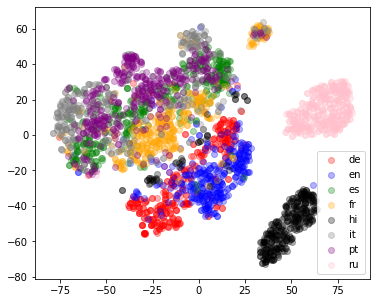




  0%|          | 0/2 [00:00<?, ?it/s]

         Name               Type Params
0          l1             Linear    6 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  





iteration: 0, accuracy: 0.8520833253860474:   0%|          | 0/2 [03:27<?, ?it/s]


iteration: 0, accuracy: 0.8520833253860474:  50%|█████     | 1/2 [03:28<03:28, 208.86s/it]

         Name               Type Params
0          l1             Linear    6 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  





iteration: 1, accuracy: 0.7649999856948853:  50%|█████     | 1/2 [06:31<03:28, 208.86s/it]


iteration: 1, accuracy: 0.7649999856948853: 100%|██████████| 2/2 [06:32<00:00, 196.29s/it]


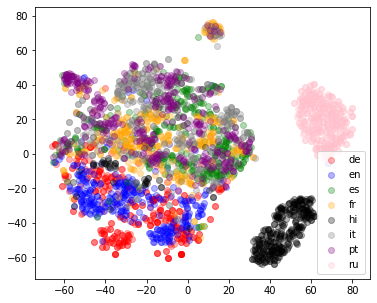




  0%|          | 0/3 [00:00<?, ?it/s]

         Name               Type Params
0          l1             Linear    6 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  





iteration: 0, accuracy: 0.8500000238418579:   0%|          | 0/3 [03:11<?, ?it/s]


iteration: 0, accuracy: 0.8500000238418579:  33%|███▎      | 1/3 [03:12<06:24, 192.35s/it]

         Name               Type Params
0          l1             Linear    6 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  





iteration: 1, accuracy: 0.7681249976158142:  33%|███▎      | 1/3 [06:18<06:24, 192.35s/it]


iteration: 1, accuracy: 0.7681249976158142:  67%|██████▋   | 2/3 [06:19<03:10, 190.75s/it]

         Name               Type Params
0          l1             Linear    6 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  





iteration: 2, accuracy: 0.7008333206176758:  67%|██████▋   | 2/3 [09:26<03:10, 190.75s/it]


iteration: 2, accuracy: 0.7008333206176758: 100%|██████████| 3/3 [09:27<00:00, 189.17s/it]


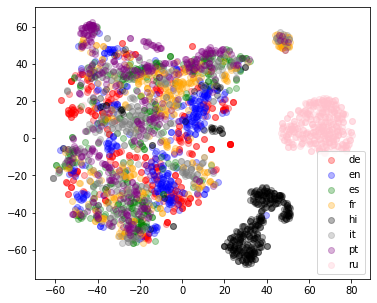




  0%|          | 0/4 [00:00<?, ?it/s]

         Name               Type Params
0          l1             Linear    6 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  





iteration: 0, accuracy: 0.856249988079071:   0%|          | 0/4 [03:00<?, ?it/s]


iteration: 0, accuracy: 0.856249988079071:  25%|██▌       | 1/4 [03:01<09:04, 181.54s/it]

         Name               Type Params
0          l1             Linear    6 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  





iteration: 1, accuracy: 0.768958330154419:  25%|██▌       | 1/4 [06:09<09:04, 181.54s/it]


iteration: 1, accuracy: 0.768958330154419:  50%|█████     | 2/4 [06:10<06:07, 183.90s/it]

         Name               Type Params
0          l1             Linear    6 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  





iteration: 2, accuracy: 0.6850000023841858:  50%|█████     | 2/4 [09:23<06:07, 183.90s/it]


iteration: 2, accuracy: 0.6850000023841858:  75%|███████▌  | 3/4 [09:25<03:06, 186.99s/it]

         Name               Type Params
0          l1             Linear    6 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  





iteration: 3, accuracy: 0.6460416913032532:  75%|███████▌  | 3/4 [12:28<03:06, 186.99s/it]


iteration: 3, accuracy: 0.6460416913032532: 100%|██████████| 4/4 [12:29<00:00, 187.38s/it]


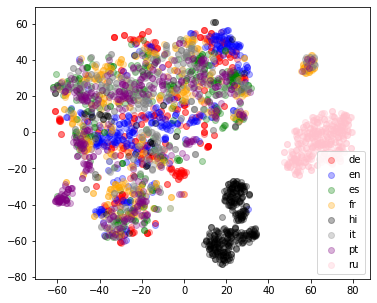

In [42]:
for num_classifiers in [1,2,3,4]:
    P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = num_classifiers, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)
    P_rowspace = np.eye(P.shape[0]) - P
    tsne(P_rowspace.dot(vecs.T).T[:3000], labels_lang[:3000])

## Classification INLP

In [37]:
inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train_cls, y_train_cls, x_dev_cls, y_dev_cls, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
#inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False, "max_iter": 5000})
inlp_model_handler = inlp_linear_model.SKlearnClassifier(SGDClassifier, {"max_iter": 10000, "alpha": 0.0001, "n_iter_no_change": 10})

### Try several different INLP dimensions



  0%|          | 0/1 [00:00<?, ?it/s]

iteration: 0, accuracy: 0.8275:   0%|          | 0/1 [00:16<?, ?it/s]

iteration: 0, accuracy: 0.8275: 100%|██████████| 1/1 [00:16<00:00, 16.44s/it]


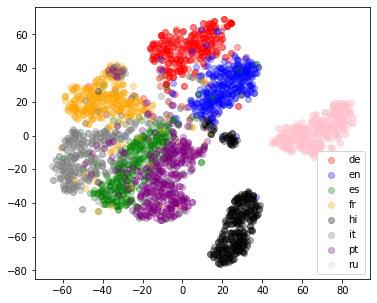



  0%|          | 0/2 [00:00<?, ?it/s]

iteration: 0, accuracy: 0.77875:   0%|          | 0/2 [00:15<?, ?it/s]

iteration: 0, accuracy: 0.77875:  50%|█████     | 1/2 [00:15<00:15, 15.70s/it]

iteration: 1, accuracy: 0.69625:  50%|█████     | 1/2 [00:35<00:15, 15.70s/it]

iteration: 1, accuracy: 0.69625: 100%|██████████| 2/2 [00:36<00:00, 18.09s/it]


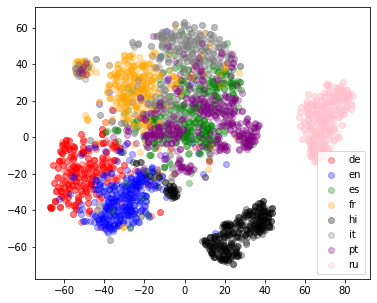



  0%|          | 0/3 [00:00<?, ?it/s]

iteration: 0, accuracy: 0.883125:   0%|          | 0/3 [00:14<?, ?it/s]

iteration: 0, accuracy: 0.883125:  33%|███▎      | 1/3 [00:15<00:30, 15.16s/it]

iteration: 1, accuracy: 0.69:  33%|███▎      | 1/3 [00:36<00:30, 15.16s/it]    

iteration: 1, accuracy: 0.69:  67%|██████▋   | 2/3 [00:36<00:16, 16.97s/it]

iteration: 2, accuracy: 0.494375:  67%|██████▋   | 2/3 [01:01<00:16, 16.97s/it]

iteration: 2, accuracy: 0.494375: 100%|██████████| 3/3 [01:01<00:00, 20.60s/it]


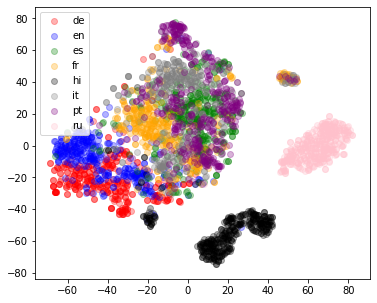



  0%|          | 0/4 [00:00<?, ?it/s]

iteration: 0, accuracy: 0.87125:   0%|          | 0/4 [00:12<?, ?it/s]

iteration: 0, accuracy: 0.87125:  25%|██▌       | 1/4 [00:12<00:36, 12.22s/it]

iteration: 1, accuracy: 0.6775:  25%|██▌       | 1/4 [00:33<00:36, 12.22s/it] 

iteration: 1, accuracy: 0.6775:  50%|█████     | 2/4 [00:33<00:29, 14.94s/it]

iteration: 2, accuracy: 0.5125:  50%|█████     | 2/4 [00:57<00:29, 14.94s/it]

iteration: 2, accuracy: 0.5125:  75%|███████▌  | 3/4 [00:57<00:17, 17.71s/it]

iteration: 3, accuracy: 0.361875:  75%|███████▌  | 3/4 [01:24<00:17, 17.71s/it]

iteration: 3, accuracy: 0.361875: 100%|██████████| 4/4 [01:24<00:00, 21.12s/it]


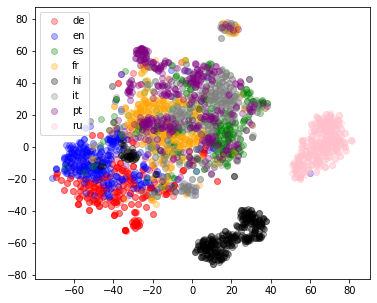

In [38]:
for num_classifiers in [1,2,3,4]:
    P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = num_classifiers, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)
    P_rowspace = np.eye(P.shape[0]) - P
    tsne(P_rowspace.dot(vecs.T).T[:3000], labels_lang[:3000])